# Imports + Path Specification

In [1]:
import sys
import os
import torch
from torch import optim
from time import time
import random

In [2]:
tile2vec_dir = '/home/agupta21/gcloud/231n_gitproject' # Uncomment for anshul
# tile2vec_dir = '/home/shailimonchik/project' # Uncomment for Shai
sys.path.append('../')
sys.path.append(tile2vec_dir)

In [3]:
from src.datasets import TileTripletsDataset, GetBands, RandomFlipAndRotate, ClipAndScale, ToFloatTensor, triplet_dataloader
from src.tilenet import make_tilenet

In [4]:
from src.training import prep_triplets, train_triplet_epoch

In [5]:
import numpy as np
from torch.autograd import Variable
import sys
from src.resnet import ResNet18

In [6]:
#Random Forest Classification

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dataloader + TileNet Setup

In [7]:
# Environment stuff
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()
print(cuda)

True


In [8]:
# Defining Parameters
img_type = 'naip'
tile_dir = '/home/agupta21/gcloud/231n_gitproject/data/triplets/'
bands = 4
augment = False
batch_size = 50
shuffle = True
num_workers = 4
n_triplets = 100000

In [9]:
dataloader = triplet_dataloader(img_type, tile_dir, bands=bands, augment=augment,
                                batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                n_triplets=n_triplets, pairs_only=True)
print('Dataloader set up complete.')

Dataloader set up complete.


In [10]:
#generate list
random.seed(21)
randList = []
while len(randList)!= 10000:
    randIndex = random.randint(0,99999)
    if randIndex not in randList:
        randList.append(randIndex)
print(len(randList))

randSet = set(randList)
print(len(randSet))
print(list(randSet)[0]) #65339

10000
10000
65539


In [11]:
# tripletsToLabels = {}
# for idx in range(65538,100000):
#     if idx in randSet:
#         #do shit
#         part1 = "../data/triplets/" + str(idx)
#         anchor = np.load(part1 + "anchor.npy")
#         neighbor = np.load(part1 + "neighbor.npy")
#         distant = np.load(part1 + "distant.npy")
#         counts_anchor = np.bincount(anchor[:,:,4].reshape(2500,))
#         anchor_label = np.argmax(counts_anchor)
#         counts_nei = np.bincount(neighbor[:,:,4].reshape(2500,))
#         neighbor_label = np.argmax(counts_nei)
#         counts_distant = np.bincount(distant[:,:,4].reshape(2500,))
#         distant_label = np.argmax(counts_distant)
#         tripletsToLabels[idx] = (anchor_label, neighbor_label, distant_label)
#     if idx == 65539:
#         print(anchor_label,neighbor_label,distant_label)
        
#         print('Key is {}, Labels are {}'.format(idx, tripletsToLabels[idx]))
#     if idx % 10000 == 0:
#         print('idx is {}'.format(idx))
# print(len(tripletsToLabels))

In [12]:
# #Get set of all values:
# allVals = set()
# for idx in range(100000):
#     if idx % 1000 == 0:
#         print(idx)
#     part1 = "../data/triplets/" + str(idx)
#     anchor = np.load(part1 + "anchor.npy")
#     neighbor = np.load(part1 + "neighbor.npy")
#     distant = np.load(part1 + "distant.npy")
#     counts_anchor = np.bincount(anchor[:,:,4].reshape(2500,))
#     anchor_label = np.argmax(counts_anchor)
#     counts_nei = np.bincount(neighbor[:,:,4].reshape(2500,))
#     neighbor_label = np.argmax(counts_nei)
#     counts_distant = np.bincount(distant[:,:,4].reshape(2500,))
#     distant_label = np.argmax(counts_distant)
#     allVals.add(anchor_label)
#     allVals.add(neighbor_label)
#     allVals.add(distant_label)
# print(len(allVals))
# print(allVals)

In [13]:
#Transform the dict: 
allVals = {1, 2, 131, 4, 3, 12, 141, 142, 21, 22, 23, 24, 152, 27, 28, 33, 36, 37, 41, 42, 43, 44, 176, 49, 48, 53, 54, 59, 61, 190, 66, 67, 195, 69, 71, 72, 74, 75, 76, 205, 204, 206, 208, 77, 209, 211, 212, 213, 216, 217, 218, 220, 225, 226, 227, 236, 237, 111, 242, 121, 122, 123, 124}
print(set(allVals))
le = LabelEncoder()
transformedLabels = le.fit_transform(list(allVals))
print(transformedLabels)
print(set(transformedLabels))


{1, 2, 3, 131, 4, 12, 141, 142, 21, 22, 23, 24, 152, 27, 28, 33, 36, 37, 41, 42, 43, 44, 176, 49, 48, 53, 54, 59, 61, 190, 66, 67, 195, 69, 71, 72, 74, 75, 76, 205, 204, 206, 208, 77, 209, 211, 212, 213, 216, 217, 218, 220, 225, 226, 227, 236, 237, 111, 242, 121, 122, 123, 124}
[ 0  1  2 38  3  4 39 40  5  6  7  8 41  9 10 11 12 13 14 15 16 17 42 19
 18 20 21 22 23 43 24 25 44 26 27 28 29 30 31 46 45 47 48 32 49 50 51 52
 53 54 55 56 57 58 59 60 61 33 62 34 35 36 37]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}


In [14]:
# tile_dir = '../data/tiles'
# n_tiles = 1000
# y = np.load(os.path.join(tile_dir, 'y.npy'))
# print(y.shape)
# print(set(y))


In [15]:
# for i in set(y):
#     val = int(i)
#     if val not in allVals:
#         print("Crushing")

In [16]:
# #DO NOT RUN THIS ANYMORE
# f = open('tripletsToLabels2', 'w')
# f.write(str(tripletsToLabels))
# f.close()

In [17]:
tempDict = eval(open('tripletsToLabels', 'r').read())
print(len(tempDict))

print(tempDict[65539])

10000
(123, 69, 69)


In [18]:
#DONT RUN THIS AGAIN!!!!! (actually you can )
for key, value in tempDict.items():
    value2 = le.transform(value)
    tempDict[key] = value2
maxVal = 0
for key, value in tempDict.items():
    maxP = max(value)
    if maxP > maxVal:
        maxVal = maxP
print(maxVal)

61


In [19]:
in_channels = bands
z_dim = 512

In [20]:
TileNet = make_tilenet(in_channels=in_channels, z_dim=z_dim, strat2=True, dictionary_labels=tempDict, idx_include=randSet)
TileNet.train()
if cuda: TileNet.cuda()
print('TileNet set up complete.')

TileNet set up complete.


In [21]:
#Hyperparameter 
lr = 1e-3
optimizer = optim.Adam(TileNet.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Model + Writing Each Epoch to File

In [22]:
epochs = 12
margin = 10
l2 = 0.01
print_every = 10000
save_models = True

In [23]:
model_dir = '/home/agupta21/gcloud/231n_gitproject/models/'
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [24]:
t0 = time()
#with open(results_fn, 'w') as file:

total_list = []
small_list = []
print('Begin training.................')
for epoch in range(0, epochs):
    (avg_loss, avg_small,avg_l_n, avg_l_d, avg_l_nd) = train_triplet_epoch(
        TileNet, cuda, dataloader, optimizer, epoch+1, margin=margin, l2=l2,
        print_every=print_every, t0=t0)
    total_list.append((epoch+1,avg_loss))
    small_list.append((epoch+1,avg_small))
    append_name = "strat2.0_ep" + str(epoch+1) + ".ckpt"
    if save_models:
        model_fn = os.path.join(model_dir,append_name)
        torch.save(TileNet.state_dict(),model_fn)

Begin training.................


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 

In [ ]:
print(total_list)
print(small_list)


# Pre Process Y Values

In [25]:
#note to self: need to embed tiles first and then figure out loop for reading in the saved model and plotting
#the classification accuracies per epoch
tile_dir = '../data/tiles'
n_tiles = 1000
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)

(1000,)


In [26]:
# Check CDL classes
print(set(y))

{1.0, 2.0, 21.0, 24.0, 152.0, 28.0, 36.0, 176.0, 49.0, 54.0, 61.0, 69.0, 71.0, 72.0, 75.0, 76.0, 205.0, 204.0, 208.0, 212.0, 217.0, 225.0, 236.0, 111.0, 121.0, 122.0, 123.0, 124.0}


In [27]:
y = le.fit_transform(y)
print(set(y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


# Load in Epochs' Weights + Run each on tile embeddings + Random Forest 

In [28]:
#set up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()

In [29]:
def getTileEmbeddings(tilenet):
    X = np.zeros((n_tiles, z_dim))
    for idx in range(n_tiles):
        tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
        # Get first 4 NAIP channels (5th is CDL mask)
        tile = tile[:,:,:4]
        # Rearrange to PyTorch order
        tile = np.moveaxis(tile, -1, 0)
        tile = np.expand_dims(tile, axis=0)
        # Scale to [0, 1]
        tile = tile / 255
        # Embed tile
        tile = torch.from_numpy(tile).float()
        tile = Variable(tile)
        if cuda: tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: z = z.cpu()
        z = z.data.numpy() #1 by 512
        X[idx,:] = z
    return X

In [30]:
epochsToAccuracy = []
epochsToSTD = []
for i in range(0,epochs): #iterator
    curEpoch = i + 1
    # Setting up model
    tilenet = ResNet18()
    if cuda: tilenet.cuda()
    model_fn = "../models/strat2.0_ep"+str(curEpoch)+".ckpt" #open file
    #checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(torch.load(model_fn), strict=False)
    #tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    
    X = getTileEmbeddings(tilenet) #function above
    
    #train random forest classifier
    n_trials = 100
    accs = np.zeros((n_trials,))
    for i in range(n_trials):
        # Splitting data and training RF classifer
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
        rf = RandomForestClassifier(n_estimators = 100)
        rf.fit(X_tr, y_tr) #X-tr is 512 by 1
        accs[i] = rf.score(X_te, y_te)
    print("Results for Epoch Number: ", str(curEpoch))
    print('Mean accuracy: {:0.4f}'.format(accs.mean()))
    print('Standard deviation: {:0.4f}'.format(accs.std()))
    epochsToAccuracy.append((curEpoch,accs.mean()))
    epochsToSTD.append((curEpoch,accs.std()))
print(epochsToAccuracy)
print(epochsToSTD)
    #save value
    
    
    
    

Results for Epoch Number:  1
Mean accuracy: 0.6620
Standard deviation: 0.0302
Results for Epoch Number:  3
Mean accuracy: 0.6785
Standard deviation: 0.0315
Results for Epoch Number:  4
Mean accuracy: 0.6781
Standard deviation: 0.0287
Results for Epoch Number:  5
Mean accuracy: 0.6813
Standard deviation: 0.0331
Results for Epoch Number:  6
Mean accuracy: 0.6788
Standard deviation: 0.0291
Results for Epoch Number:  7
Mean accuracy: 0.6855
Standard deviation: 0.0280
Results for Epoch Number:  8
Mean accuracy: 0.6853
Standard deviation: 0.0302
Results for Epoch Number:  9
Mean accuracy: 0.6971
Standard deviation: 0.0302
Results for Epoch Number:  10
Mean accuracy: 0.6993
Standard deviation: 0.0293
Results for Epoch Number:  11
Mean accuracy: 0.6919
Standard deviation: 0.0322
Results for Epoch Number:  12
Mean accuracy: 0.7024
Standard deviation: 0.0293
[(1, 0.66195), (2, 0.6496999999999999), (3, 0.67855), (4, 0.6781499999999998), (5, 0.6813000000000001), (6, 0.6788), (7, 0.6855), (8, 0.685

In [ ]:
print(epochsToSTD)

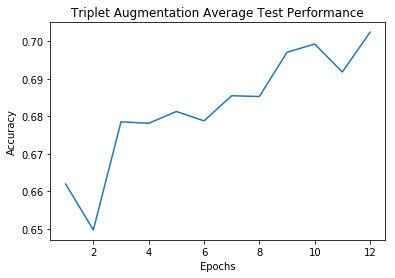

0.7024499999999999 was the Max Accuracy


In [33]:
import matplotlib.pyplot as plt
plt.plot(*zip(*epochsToAccuracy))
plt.title('Triplet Augmentation Average Test Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(epochsToAccuracy[11][1], "was the Max Accuracy")

IndexError: list index out of range

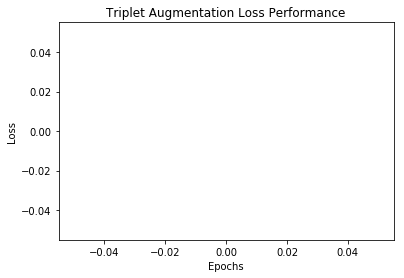

In [32]:
plt.plot(*zip(*total_list))
plt.title('Triplet Augmentation Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print("The min loss was",str(total_list[9][1]))
plt.show()

In [ ]:
plt.plot(*zip(*epochsToSTD))
plt.title('STD on Random Forest Test Prediction')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()